In [1]:
import cv2
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models

In [2]:
import torchvision
m = torchvision.models.__dict__

# Data

In [3]:
image_dir = './data/Images'
train_path = './data/Train.csv'
test_path = './data/Test.csv'
pred_path = './submissions/ensemble_4x_resnet18.csv'

In [4]:
df = pd.read_csv(train_path)
df.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [5]:
test_df = pd.read_csv(test_path)
test_df.head()

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl
3,ID_06gzqIwK
4,ID_08kWat36


In [6]:
df['Target'].value_counts()

1    3771
0    3229
Name: Target, dtype: int64

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


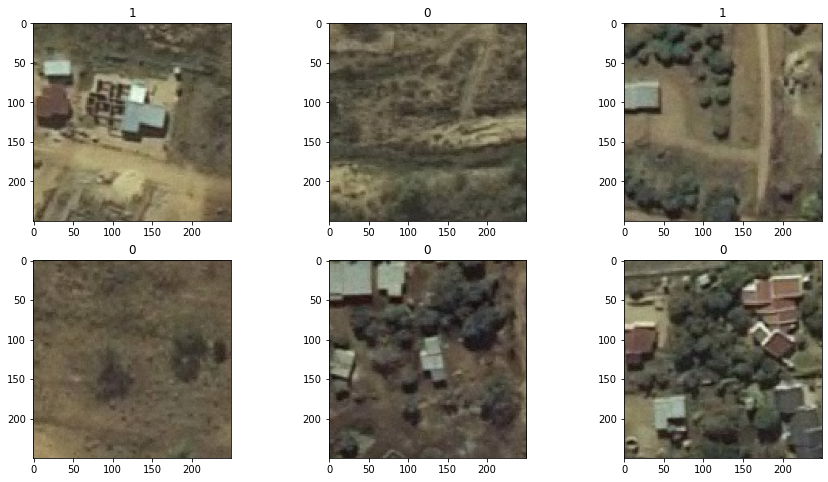

In [8]:
from utils import show_random

show_random(df, image_dir)

# Check augmentations

In [9]:
from dataset import RoadSegment
from utils import get_transform, visualize_augmentations
import albumentations as A

train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.Rotate(limit=45, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, idx=10)

TypeError: visualize_augmentations() got an unexpected keyword argument 'idx'

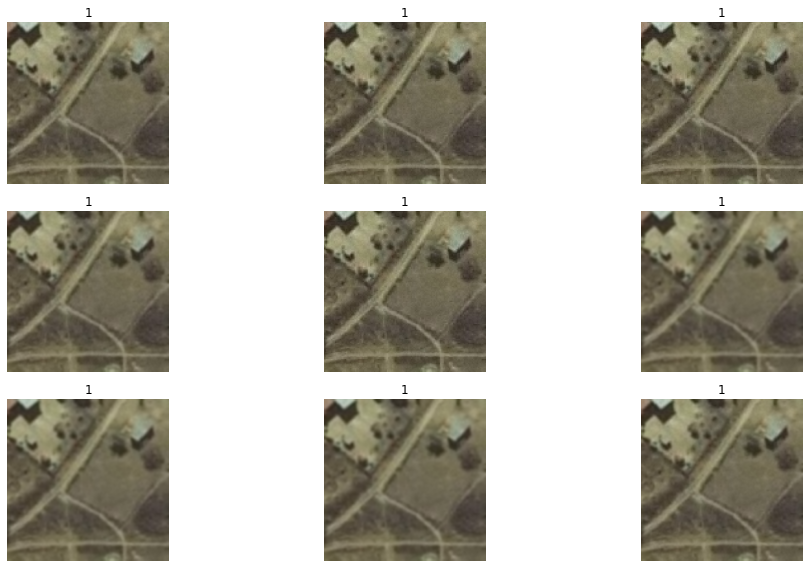

In [11]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.Rotate(limit=45, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)

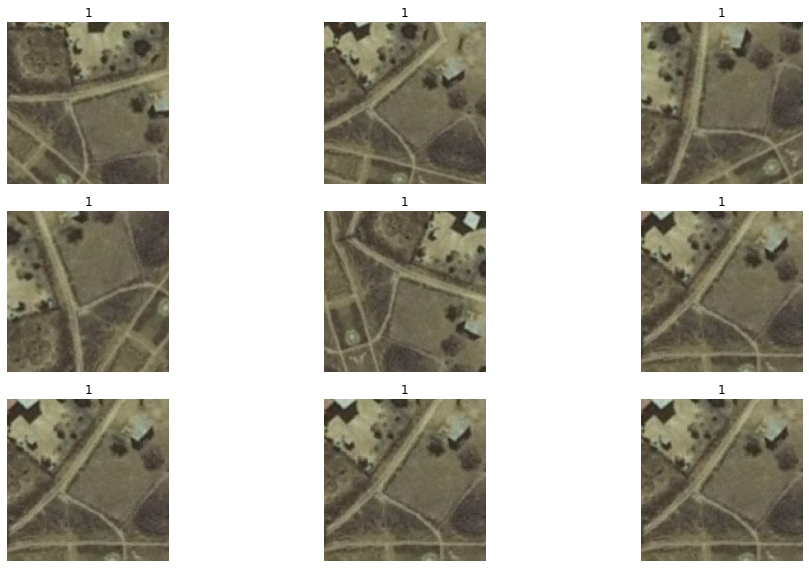

In [13]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)

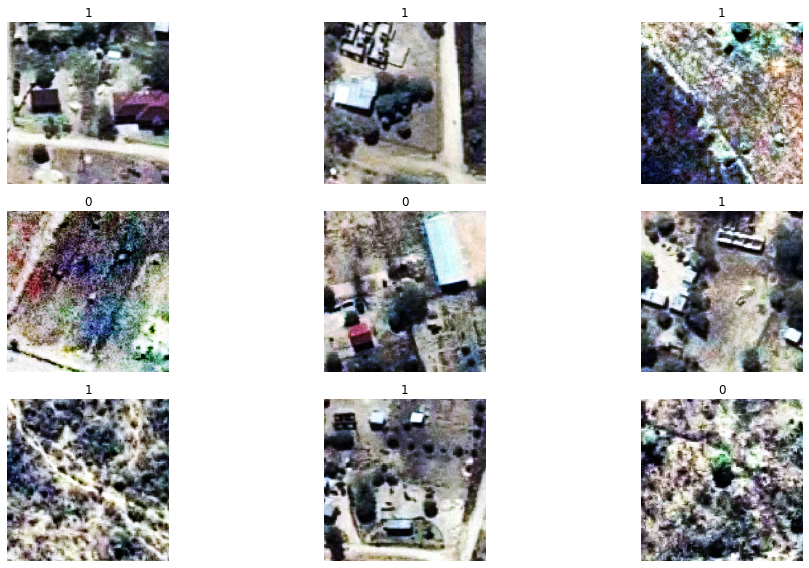

In [14]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.Equalize(p=1)
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset)

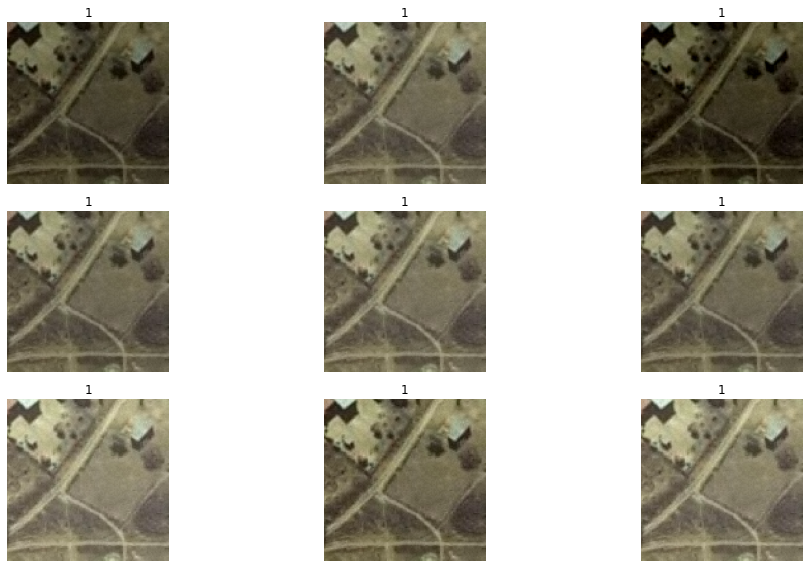

In [16]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.Equalize(p=1)
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)